# 지도학습 vs 비지도학습: 파이썬 기초 예제 (PIMA & MNIST)

이 노트북은 '지도학습 vs 비지도학습' 발표 자료를 바탕으로, 머신러닝의 핵심 개념을 파이썬 코드로 직접 실행해보는 학습용 예제입니다.

**학습 목표:**
1.  **지도학습 (회귀):** 간단한 선형 회귀(Linear Regression) 모델을 학습시킵니다.
2.  **지도학습 (분류):** PIMA 당뇨병 데이터를 사용하여 이진 분류 모델을 학습시킵니다.
3.  **비지도학습 (차원축소 & 군집):** MNIST 손글씨 데이터를 사용하여 차원축소(PCA)와 군집(K-Means)을 수행합니다.

**사용 라이브러리:**
* `scikit-learn`: 머신러닝 모델 생성 및 데이터셋 로드
* `matplotlib`: 데이터 시각화
* `numpy`: 수치 연산
* `pandas`: 데이터 로드 (PIMA)
* `seaborn`: 시각화 (Confusion Matrix)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. 지도학습 (Supervised Learning)

지도학습은 **정답(label)** 이 있는 데이터를 학습하는 방식입니다. 모델은 입력(Input X)을 보고 정답(Output Y)을 맞추도록 훈련됩니다.

## 1.1 데이터 준비 (PIMA 당뇨병 데이터셋)
PIMA 데이터셋은 헤더(column 이름)가 없으므로 직접 지정해줍니다.
출처:
* [Pima Indians Diabetes Database | Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html


**데이터 구성**
* Pregnancies : 임신 횟수
* Glucose : 2시간 동안의 경구 포도당 내성 검사에서 혈장 포도당 농도 
* BloodPressure : 이완기 혈압 (mm Hg)
* SkinThickness : 삼두근 피부 주름 두께 (mm), 체지방을 추정하는데 사용되는 값
* Insulin : 2시간 혈청 인슐린 (mu U / ml)
* BMI : 체질량 지수 (체중kg / 키(m)^2)
* DiabetesPedigreeFunction : 당뇨병 혈통 기능
* Age : 나이
* Outcome : 768개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0입니다.

In [2]:
df1 = pd.read_csv("http://bit.ly/data-diabetes-csv")
df1.shape

(768, 9)

In [3]:
df1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### EDA

In [4]:
df1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

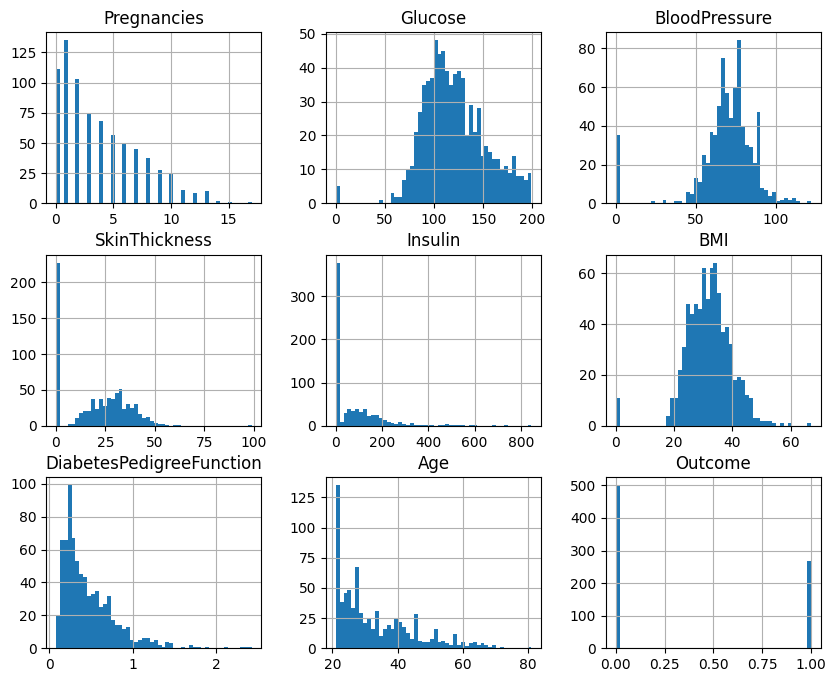

In [5]:
df1.hist(figsize=(10, 8), bins=50)

<Axes: xlabel='Pregnancies', ylabel='count'>

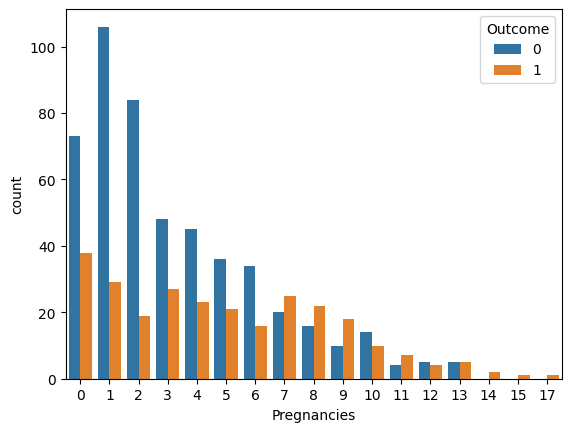

In [6]:
sns.countplot(data=df1, x="Pregnancies", hue="Outcome")

## 1.2 지도학습: 회귀(Regression)

정답(Label)이 연속적인 값(continuous)일 때 사용합니다.

### 데이터 전처리: 결측치

PIMA 데이터에서 0은 결측치를 의미하는 경우가 많습니다. (BMI(mass), 혈압(pres) 등)

In [7]:
df1_reg = df1.copy()
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df1_reg[cols_with_zeros] = df1_reg[cols_with_zeros].replace(0, np.nan)
df1_reg = df1_reg.dropna()
df1_reg.shape

(392, 9)

In [8]:
print(f"원본 데이터 수: {len(df1)}, 결측치 제거 후 데이터 수: {len(df1_reg)}")

원본 데이터 수: 768, 결측치 제거 후 데이터 수: 392


### 데이터 분할 및 스케일링

In [9]:
feature_names_reg = df1_reg.columns.tolist()
feature_names_reg.remove("Outcome")
feature_names_reg.remove("BMI")
label_name_reg = "BMI"

In [10]:
#  X 와 y 를 만듭니다.
X = df1_reg[feature_names_reg]
y = df1_reg[label_name_reg]

In [11]:
# For regression (predicting continuous BMI) do NOT stratify by y.
# Stratify is only appropriate for classification labels (discrete classes).
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# StandardScaler를 사용하여 데이터 스케일 조정
scaler = StandardScaler()
Xr_train_scaled = scaler.fit_transform(Xr_train)
Xr_test_scaled = scaler.transform(Xr_test)

## 1.2.1 회귀 모델: Linear Regression

### 모델 생성

In [13]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(Xr_train_scaled, yr_train)

LinearRegression()

### 모델 평가 (MSE, R2)

In [14]:
yr_lin_pred = model_lin_reg.predict(Xr_test_scaled)
mse = np.square(yr_test - yr_lin_pred).mean()
r2 = r2_score(yr_test, yr_lin_pred)

In [15]:
print(f"Linear Regression (PIMA BMI 예측)")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Linear Regression (PIMA BMI 예측)
Mean Squared Error: 29.74010719812152
R^2 Score: 0.3914613215162699


### 시각화 (실제값 vs 예측값)

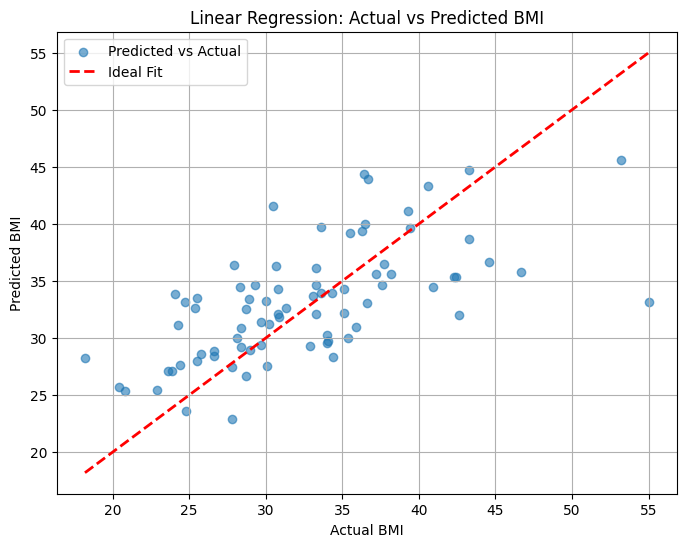

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(yr_test, yr_lin_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Linear Regression: Actual vs Predicted BMI')
plt.legend()
plt.grid(True)
plt.show()

## 1.2.2 회귀 모델: Random Forest Regression

### 모델 생성

In [17]:
model_ran_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_ran_reg.fit(Xr_train_scaled, yr_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

### 모델 평가

In [18]:
yr_ran_pred = model_ran_reg.predict(Xr_test_scaled)
mse_ran = np.square(yr_test - yr_ran_pred).mean()
r2_ran = r2_score(yr_test, yr_ran_pred)

In [19]:
print(f"Random Forest Regression (PIMA BMI 예측)")
print(f"Mean Squared Error: {mse_ran}")
print(f"R^2 Score: {r2_ran}")

Random Forest Regression (PIMA BMI 예측)
Mean Squared Error: 25.44837191139239
R^2 Score: 0.4792783190270624


### 시각화 (실제값 vs 예측값)

In [20]:
df_y = pd.DataFrame({"true" : yr_test, "predict" : yr_ran_pred})

<Axes: ylabel='Density'>

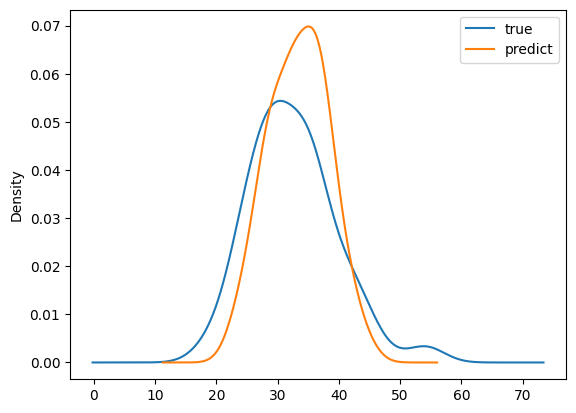

In [21]:
df_y.plot(kind="kde")

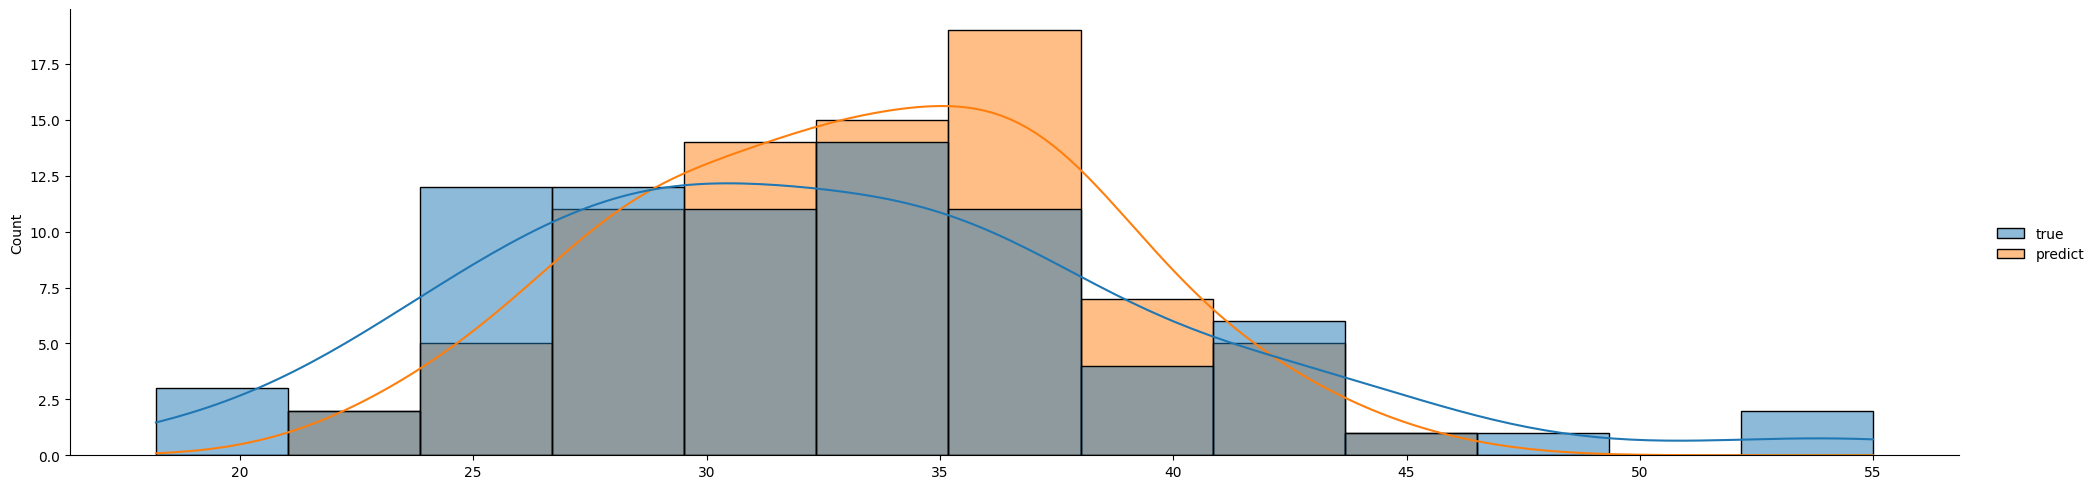

In [22]:
sns.displot(df_y, kde=True, aspect=4)

## 1.3 지도학습: 분류(Classification)

정답(Label)이 범주형(categorical)일 때 (예: 0 또는 1, A/B/C) 분류라고 합니다.

### 데이터 전처리: 결측치

In [23]:
df1_class = df1.copy()

# Insulin의 0 값을 결측치로 만들어 Insulin_nan 이라는 새로운 컬럼을 만들기
df1_class["Insulin_nan"] = df1_class["Insulin"].replace(0, np.nan)

# 결측치 수
insulNanSum = df1_class["Insulin_nan"].isnull().sum()

# 결측치 비율
insulNanRatio = df1_class["Insulin_nan"].isnull().mean() * 100

print(f"Insulin_nan 결측치 수: {insulNanSum}")
print(f"Insulin_nan 결측치 비율: {insulNanRatio:.2f}%")

Insulin_nan 결측치 수: 374
Insulin_nan 결측치 비율: 48.70%


In [24]:
# groupby 로 당뇨병 여부에 따라 평균, 중앙값 구하기
df1_class.groupby("Outcome")[["Insulin", "Insulin_nan"]].describe()

Insulin                                                         \
          count        mean         std  min  25%   50%     75%    max   
Outcome                                                                  
0         500.0   68.792000   98.865289  0.0  0.0  39.0  105.00  744.0   
1         268.0  100.335821  138.689125  0.0  0.0   0.0  167.25  846.0   

        Insulin_nan                                                             
              count        mean         std   min    25%    50%     75%    max  
Outcome                                                                         
0             264.0  130.287879  102.482237  15.0   66.0  102.5  161.25  744.0  
1             130.0  206.846154  132.699898  14.0  127.5  169.5  239.25  846.0

In [25]:
# 결측치 채우기
Insulin_mean = df1_class.groupby("Outcome")["Insulin_nan"].mean()
df1_class["Insulin_fill"] = df1_class["Insulin_nan"]
df1_class.loc[(df1_class["Outcome"] == 0) & df1_class["Insulin_nan"].isnull(), "Insulin_fill"] = Insulin_mean[0]
df1_class.loc[(df1_class["Outcome"] == 1) & df1_class["Insulin_nan"].isnull(), "Insulin_fill"] = Insulin_mean[1]

In [26]:
df1_class[["Insulin", "Outcome", "Insulin_nan", "Insulin_fill"]].sample(5)

,Insulin,Outcome,Insulin_nan,Insulin_fill
394,0,1,NaN,206.846154
490,66,0,66.0,66.000000
555,215,0,215.0,215.000000
393,87,0,87.0,87.000000
225,32,0,32.0,32.000000


### 데이터 전처리: 이상치(Outlier)

<Axes: xlabel='Insulin_nan'>

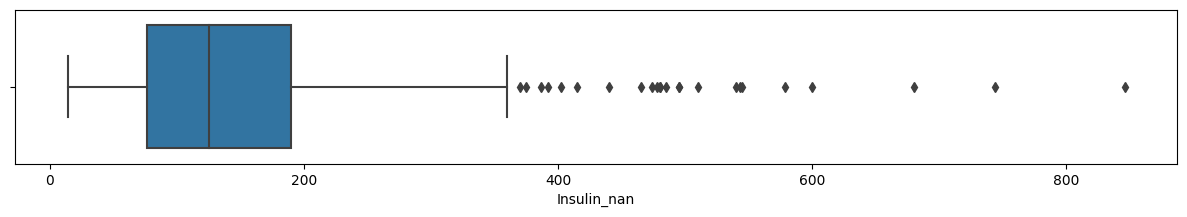

In [27]:
plt.figure(figsize=(15, 2))
sns.boxplot(x=df1_class["Insulin_nan"], orient="h")

In [28]:
df1_class["Insulin_nan"].describe()

count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin_nan, dtype: float64

In [29]:
# 이상치 찾기
Q1 = df1_class["Insulin_nan"].quantile(0.25)
Q3 = df1_class["Insulin_nan"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df1_class[(df1_class["Insulin_nan"] < lower_bound) | (df1_class["Insulin_nan"] > upper_bound)]
print(f"이상치 개수: {outliers.shape[0]}")

이상치 개수: 24


### 데이터 분할 및 스케일링

In [30]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.
feature_names_class = df1_class.columns.tolist()
feature_names_class.remove("Outcome")
feature_names_class

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Insulin_nan',
 'Insulin_fill']

In [31]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.
label_name_class = "Outcome"
label_name_class

'Outcome'

In [32]:
#  X 와 y 를 만듭니다.
X = df1_class[feature_names_class]
y = df1_class[label_name_class]

In [33]:
# 데이터를 학습용과 테스트용으로 분리합니다.
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
# SimpleImputer를 사용하여 결측치 처리
imputer = SimpleImputer(strategy='mean')
Xc_train_imputed = imputer.fit_transform(Xc_train)
Xc_test_imputed = imputer.transform(Xc_test)

# StandardScaler를 사용하여 데이터 스케일 조정
scaler = StandardScaler()
Xc_train_scaled = scaler.fit_transform(Xc_train_imputed)
Xc_test_scaled = scaler.transform(Xc_test_imputed)

## 1.3.1 Logistic Regression
* 로지스틱 회귀는 이름에 '회귀'가 들어가지만, 실제로는 **분류(Classification)** 알고리즘입니다.
* 선형 회귀처럼 입력 특성(feature)의 가중치 합을 계산하지만, 그 결과를 그대로 출력하는 것이 아니라 **시그모이드(Sigmoid) 함수** 를 통과시켜 0과 1 사이의 **확률(Probability)** 값으로 변환합니다.
* 결과를 확률로 해석할 수 있어 유용합니다. (예: 이 환자가 당뇨병일 확률이 70%이다.)
* 모델이 비교적 단순하고 학습 속도가 빨라, 베이스라인 모델로 자주 사용됩니다.
* 선형 모델이므로, 특성이 결과에 긍정적인 영향(계수 > 0)을 주는지 부정적인 영향(계수 < 0)을 주는지 해석하기 쉽습니다. (화이트박스 모델)
* 선형적으로 구분되지 않는 복잡한 데이터에서는 성능이 낮을 수 있습니다.\n",
* 특성들의 스케일(단위)에 영향을 받으므로, `StandardScaler` 등을 사용한 데이터 스케일링(정규화)이 종종 필요합니다.
```python
    LogisticRegression(
        *,
        penalty='l2', # 규제(Regularization)에 사용될 페널티 지정 {'l1', 'l2', 'elasticnet', 'none'}, default='l2'
        dual=False,
        tol=0.0001,
        C=1.0, # 규제 강도의 역수. 작을수록 강한 규제를 의미. default=1.0\n",
        fit_intercept=True,
        intercept_scaling=1,
        class_weight=None,
        random_state=None, # 실행했을 때 같은 결과가 나오도록 하는 시드값\n",
        solver='lbfgs', # 최적화 문제에 사용할 알고리즘 {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'
        max_iter=100, # 알고리즘이 수렴하기 위한 최대 반복 횟수
        multi_class='auto',
        verbose=0,
        warm_start=False,
        n_jobs=None,
        l1_ratio=None
    )
```

* **주요 파라미터**
    * `penalty`: 과적합(Overfitting)을 막기 위한 규제(Regularization) 방식을 정합니다. L2가 기본이며, 데이터에 비해 특성이 너무 많을 때 L1을 사용하면 일부 특성의 가중치를 0으로 만들어 특성 선택 효과를 줄 수 있습니다.
    * `C`: 규제 강도를 조절합니다. `1 / (규제 강도)`와 같습니다. `C` 값이 작아지면 규제가 강해져(모델이 단순해져) 과적합을 방지하지만, 너무 작으면 과소적합(Underfitting)이 될 수 있습니다.
    * `solver`: 학습에 사용할 최적화 알고리즘을 선택합니다. 데이터셋의 크기나 `penalty` 설정에 따라 적절한 `solver`가 다릅니다. `liblinear`는 작은 데이터셋에, `saga`는 L1 규제와 대용량 데이터셋에 좋습니다. `lbfgs`가 일반적으로 많이 쓰입니다.
    * `max_iter`: 최적화 알고리즘이 정답을 찾기 위해 시도할 최대 반복 횟수입니다. 모델이 수렴하지 않았다는 경고가 뜨면 이 값을 늘려주어야 합니다.
    * `random_state`: 재현 가능성(실행할 때마다 같은 결과가 나오도록)을 위한 난수 시드입니다."

### 모델 생성

In [35]:
model_clf = LogisticRegression(max_iter=1000, random_state=42)
model_clf.fit(Xc_train_scaled, yc_train)

LogisticRegression(max_iter=1000, random_state=42)

### 모델 평가 (테스트 데이터로 정확도 측정)

In [36]:
yc_clf_pred = model_clf.predict(Xc_test_scaled)
accuracy_clf = accuracy_score(yc_test, yc_clf_pred)
print(f"Logistic Regression (PIMA 당뇨병 예측) 정확도: {accuracy_clf}")

Logistic Regression (PIMA 당뇨병 예측) 정확도: 0.8766233766233766


### 시각화 (Confusion Matrix)

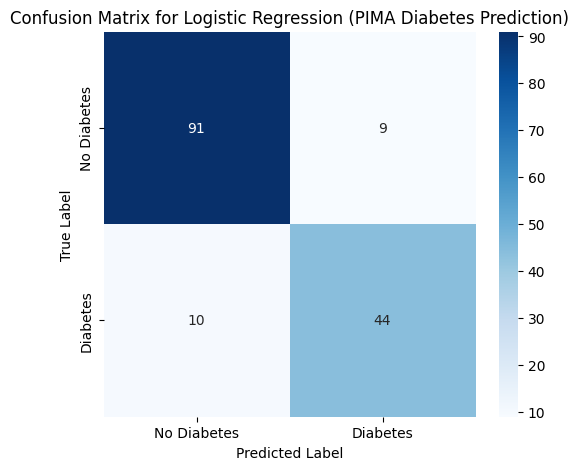

In [37]:
cm = confusion_matrix(yc_test, yc_clf_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression (PIMA Diabetes Prediction)')
plt.show()

## 1.3.2 Decision Tree
* 결과를 해석하고 이해하기 쉽다.간략한 설명만으로 결정 트리를 이해하는 것이 가능하다.
* 자료를 가공할 필요가 거의 없다.다른 기법들의 경우 자료를 정규화하거나 임의의 변수를 생성하거나 값이 없는 변수를 제거해야 하는 경우가 있다.
* 수치 자료와 범주 자료 모두에 적용할 수 있다.다른 기법들은 일반적으로 오직 한 종류의 변수를 갖는 데이터 셋을 분석하는 것에 특화되어 있다. (일례로 신경망 학습은 숫자로 표현된 변수만을 다룰 수 있는 것에 반해 관계식(relation rules)은 오직 명목 변수만을 다룰 수 있다.
* 화이트박스 모델을 사용한다. 모델에서 주어진 상황이 관측 가능하다면 불 논리를 이용하여 조건에 대해 쉽게 설명할 수 있다. (결과에 대한 설명을 이해하기 어렵기 때문에 인공신경망은 대표적인 블랙 박스 모델이다.)
* 안정적이다. 해당 모델 추리의 기반이 되는 명제가 다소 손상되었더라도 잘 동작한다.
* 대규모의 데이터 셋에서도 잘 동작한다. 방대한 분량의 데이터를 일반적인 컴퓨터 환경에서 합리적인 시간 안에 분석할 수 있다.

```python
DecisionTreeClassifier(
    *,
    criterion='gini', # 분할방법 {"gini", "entropy"}, default="gini"
    splitter='best',
    max_depth=None, # The maximum depth of the tree
    min_samples_split=2, # The minimum number of samples required to split an internal node
    min_samples_leaf=1, # The minimum number of samples required to be at a leaf node.
    min_weight_fraction_leaf=0.0, # The minimum weighted fraction of the sum total of weights
    max_features=None, # The number of features to consider when looking for the best split
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)
```

* 주요 파라미터
    * criterion: 가지의 분할의 품질을 측정하는 기능입니다.
    * max_depth: 트리의 최대 깊이입니다.
    * min_samples_split:내부 노드를 분할하는 데 필요한 최소 샘플 수입니다.
    * min_samples_leaf: 리프 노드에 있어야 하는 최소 샘플 수입니다.
    * max_leaf_nodes: 리프 노드 숫자의 제한치입니다.
    * random_state: 추정기의 무작위성을 제어합니다. 실행했을 때 같은 결과가 나오도록 합니다.

### 모델 생성

In [38]:
model_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
model_tree.fit(Xc_train_scaled, yc_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

### 모델 평가

In [39]:
# 예측
yc_tree_pred = model_tree.predict(Xc_test_scaled)
accuracy_tree = accuracy_score(yc_test, yc_tree_pred)
print(f"Decision Tree (PIMA 당뇨병 예측) 정확도: {accuracy_tree}")

Decision Tree (PIMA 당뇨병 예측) 정확도: 0.9025974025974026


### 시각화

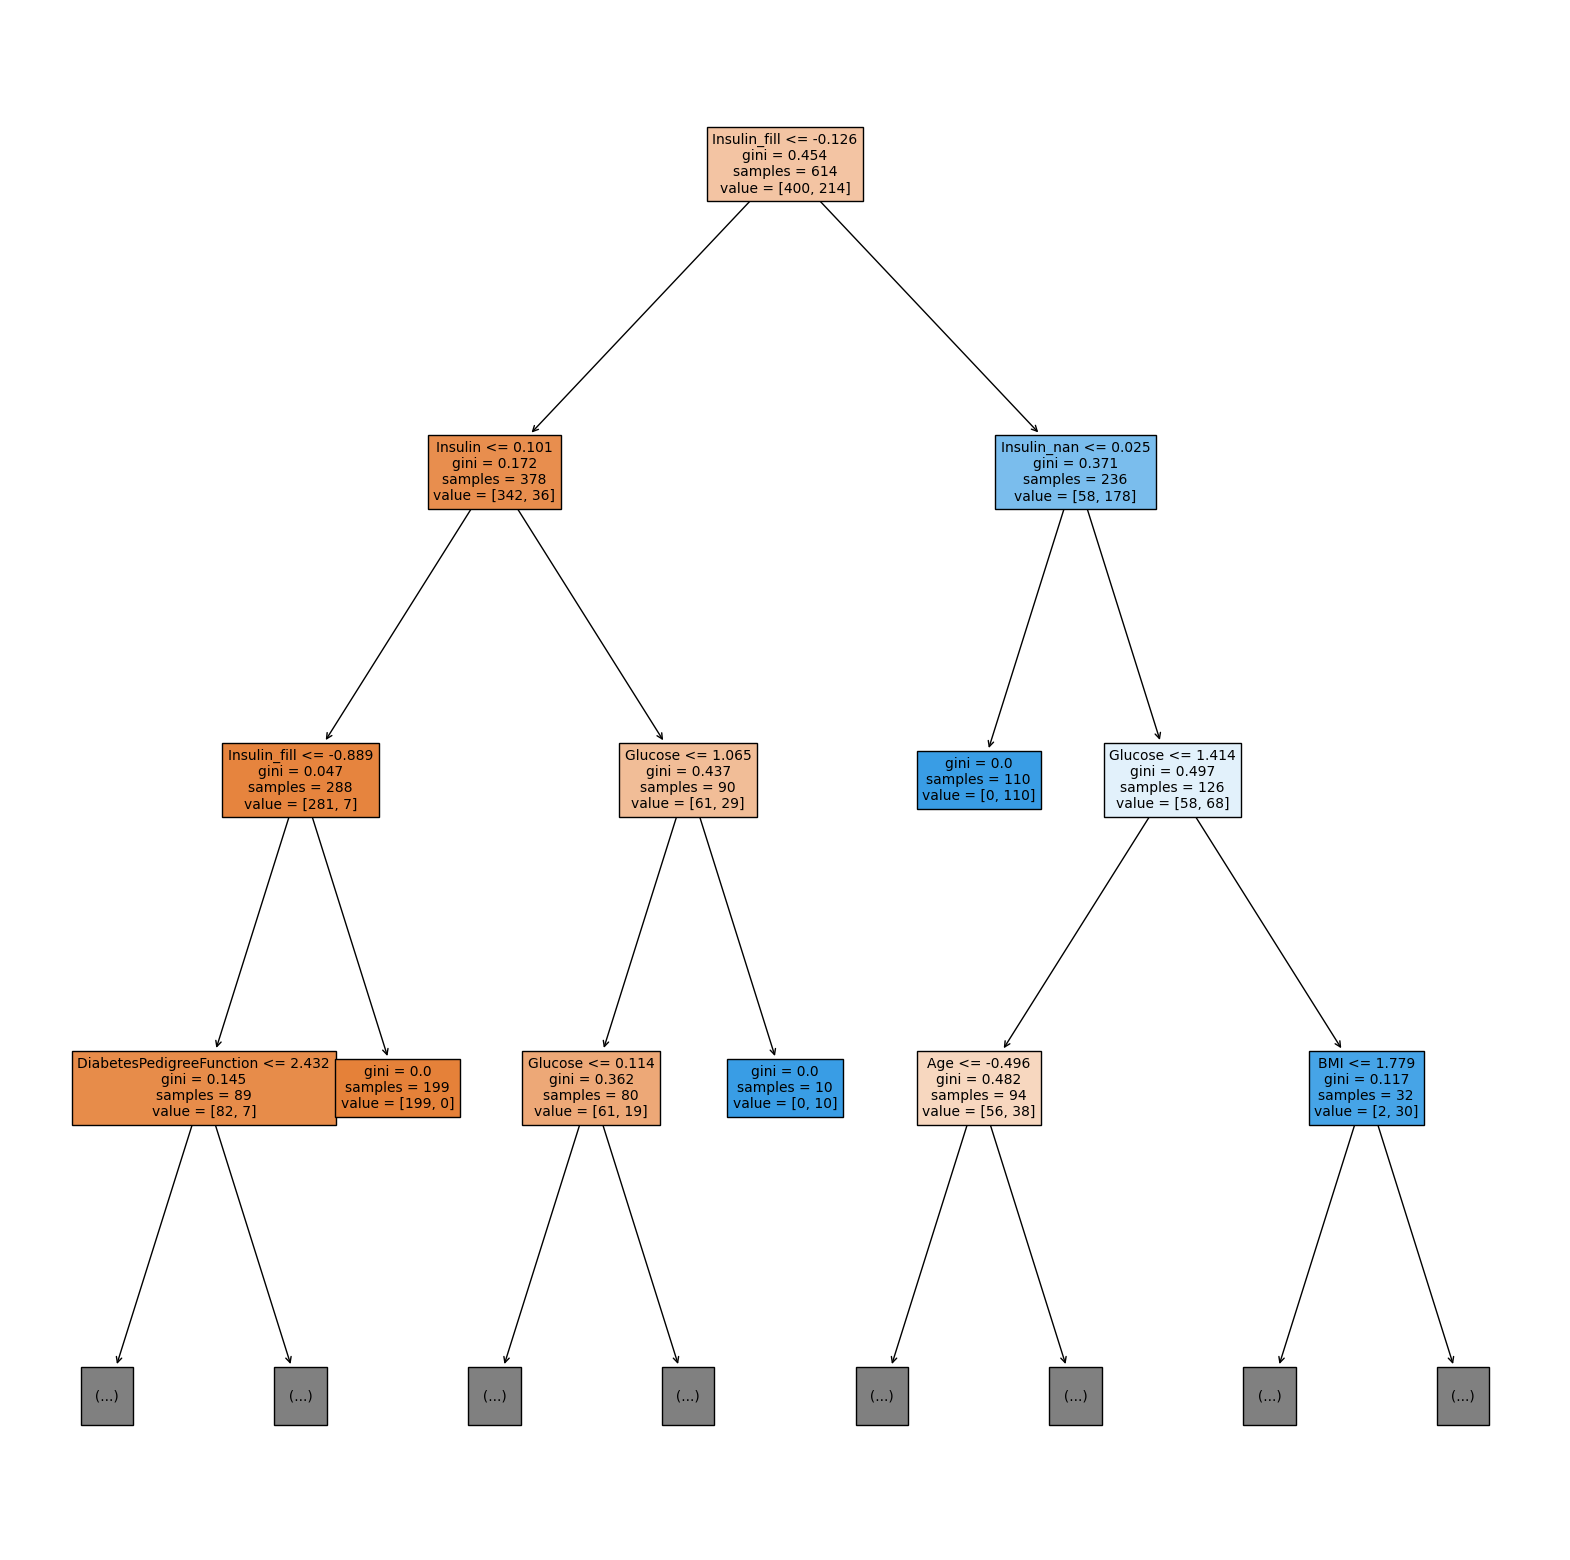

In [40]:
plt.figure(figsize=(20, 20))
ptree = plot_tree(model_tree, max_depth=3, feature_names=feature_names_class, filled=True, fontsize=10)
plt.show()

# 2. 비지도학습 (Unsupervised Learning): 차원축소 & 군집
비지도학습은 **정답(label)이 없는** 데이터에서 숨겨진 패턴이나 구조를 찾는 방식입니다.
데이터가 어떻게 구성되어 있는지, 어떤 데이터끼리 유사한지 등을 모델이 **스스로** 파악합니다. 대표적인 예로 **군집(Clustering)** 과 **차원축소(Dimensionality Reduction)** 가 있습니다.

## 2.1 데이터 준비 (MNIST 손글씨 데이터셋 축소 버전)

출처:
* Yann LeCun의 웹사이트에서 원래 제공되었습니다.
* 현재는 TensorFlow, Keras, PyTorch, scikit-learn 등 대부분의 주요 딥러닝 및 머신러닝 라이브러리에서 내장 함수를 통해 쉽게 불러올 수 있습니다. (해당 예제에서는 사이킷런의 내장함수로 데이터셋을 불러오겠습니다.)

**데이터 구성**

이미지 (Image):
* 28x28 픽셀 크기의 흑백 손글씨 숫자 이미지 (0부터 9까지).
* 각 픽셀 값은 **0에서 255** 사이의 정수(밝기 강도)를 가지며, 일반적으로 모델 학습 전에 **0.0에서 1.0** 사이로 정규화하여 사용합니다.
* 1차원으로 펼치면 28x28 = **784** 개의 특성(feature) 벡터가 됩니다.

레이블 (Label):
* 이미지가 나타내는 실제 숫사 (0, 1, 2, ..., 9). 총 10개의 클래스입니다.
* 일반적으로는 숫자 값으로 제공되지만, 분류 모델 학습을 위해 One-Hot Encoding 형태로 변환하여 사용하기도 합니다.

In [41]:
digits = load_digits()
X, y = digits.data, digits.target

In [42]:
print(f"원본 데이터 형태: {X.shape}, 레이블 형태: {y.shape}")

원본 데이터 형태: (1797, 64), 레이블 형태: (1797,)


## 2.2 차원 축소 (PCA)
* 64차원 -> 2차원으로 축소 (시각화 목적)
* PCA는 데이터의 분산을 가장 잘 보존하는 새로운 축(2개)을 찾습니다.

In [43]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

In [44]:
print(f"PCA 축소 후 데이터 형태: {X_pca.shape}")

PCA 축소 후 데이터 형태: (1797, 2)


## 2.3 군집 (K-Means)
* 비지도 학습: 정답(y_true)을 사용하지 않고, 64차원 원본 데이터(X)로 10개(0~9)의 그룹으로 군집화
* K-Means는 데이터들을 10개의 '중심점(center)'으로 묶습니다.

In [45]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

## 2.4 시각화 (PCA 2D 평면에 군집 결과 vs. 실제 정답)

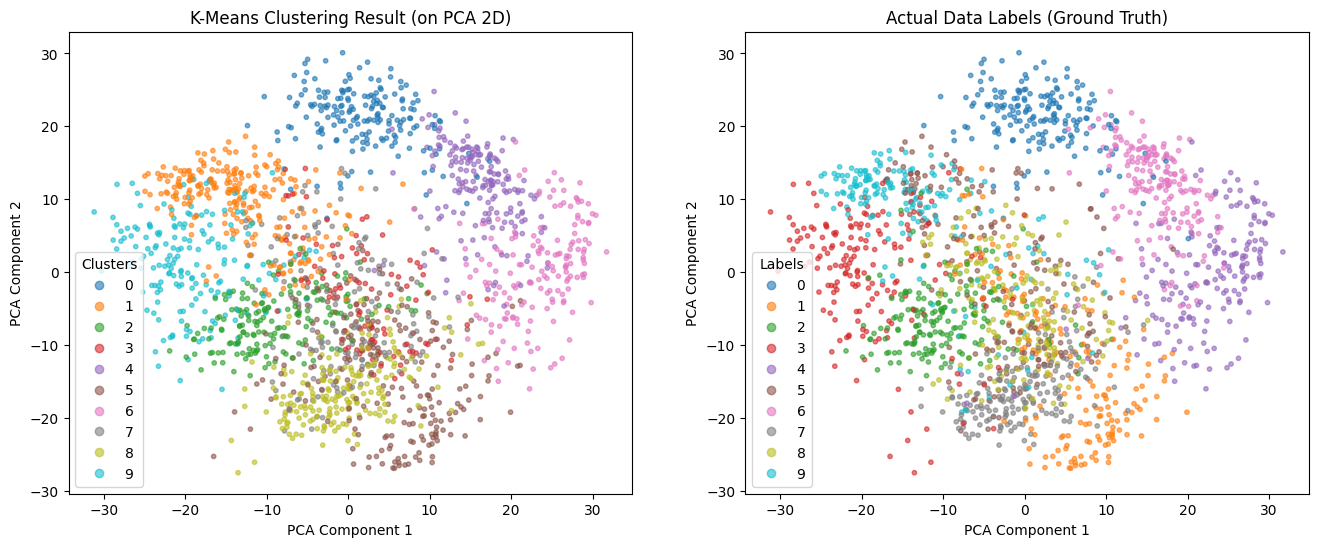

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.6, s=10)
ax1.set_title('K-Means Clustering Result (on PCA 2D)')
ax1.legend(*scatter1.legend_elements(), title='Clusters')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6, s=10)
ax2.set_title('Actual Data Labels (Ground Truth)')
ax2.legend(*scatter2.legend_elements(), title='Labels')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
plt.show()

## 2.5 (보너스) K-Means가 찾은 각 클러스터의 중심 시각화
* K-Means 모델은 64차원 원본(X)으로 학습했습니다.
* 각 10개 클러스터의 중심점(centers) 또한 64차원입니다.
* 이 64차원 중심점을 8x8 이미지로 복원하여 어떤 형태를 학습했는지 확인합니다.

In [47]:
centers = kmeans.cluster_centers_.reshape(10, 8, 8) # 64 -> 8x8 이미지로 복원

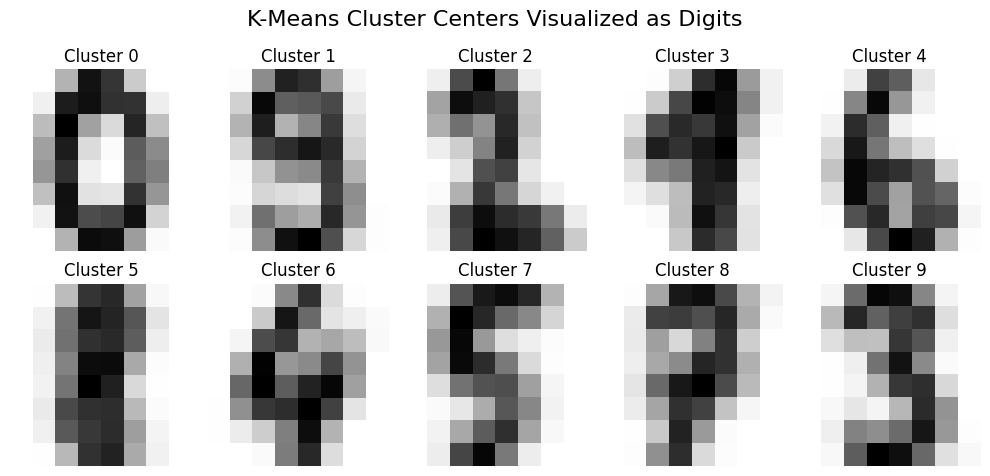

In [48]:
plt.figure(figsize=(10, 5))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(centers[i], cmap='binary', interpolation='nearest')
    plt.title(f'Cluster {i}')
    plt.axis('off')

plt.suptitle('K-Means Cluster Centers Visualized as Digits', fontsize=16)
plt.tight_layout()
plt.show()